# Import required libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from sklearn.preprocessing import LabelEncoder

# Import data

In [46]:
# data url
train_data_url = "./data/train.csv"
test_data_url = "./data/test.csv"

In [47]:
# converting df
train_df = pd.read_csv(train_data_url)
test_df = pd.read_csv(test_data_url)

# Visualize data

In [48]:
# train dataframe
train_df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [49]:
# test dataframe
test_df

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler


# Data error correction

In [50]:
train_df["num_sold"] = train_df["num_sold"].fillna(train_df["num_sold"].mean())

train_df

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,752.527382
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.000000
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.000000
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.000000
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.000000
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.000000
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.000000
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.000000
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.000000


# Data analyse

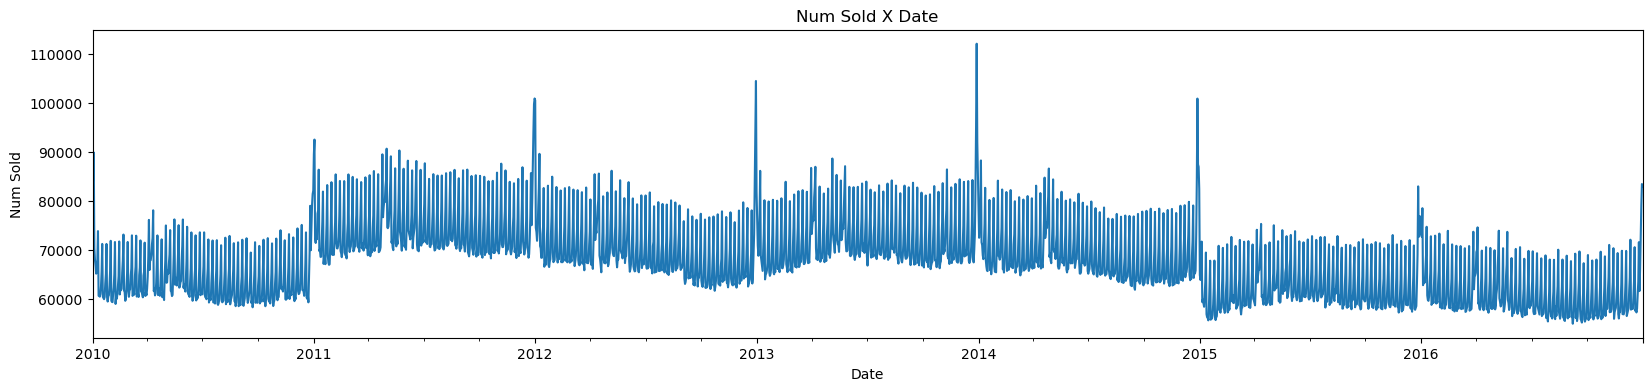

In [51]:
# understading the features of the dataframe, now we must to analyse the relationship between the features

# best seller year
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
train_df.groupby("date")["num_sold"].sum().plot(figsize=(20, 4))

plt.title("Num Sold X Date")
plt.xlabel("Date")
plt.ylabel("Num Sold")
plt.show()

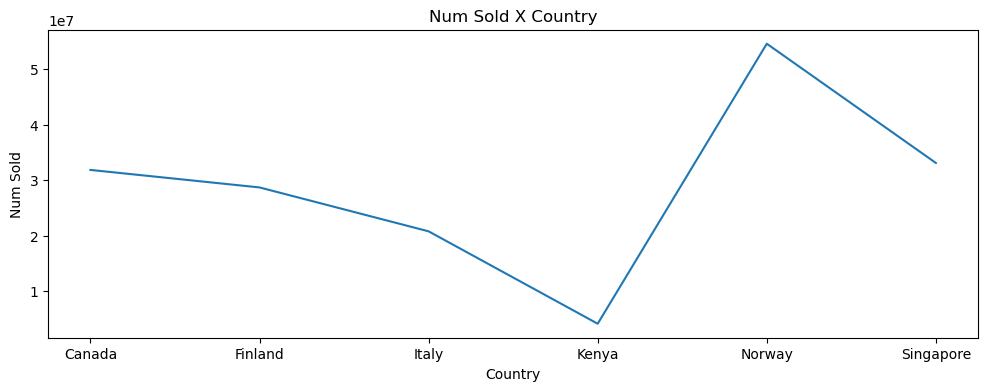

In [52]:
# best seller country
train_df.groupby("country")["num_sold"].sum().plot(figsize=(12, 4))

plt.title("Num Sold X Country")
plt.xlabel("Country")
plt.ylabel("Num Sold")
plt.show()

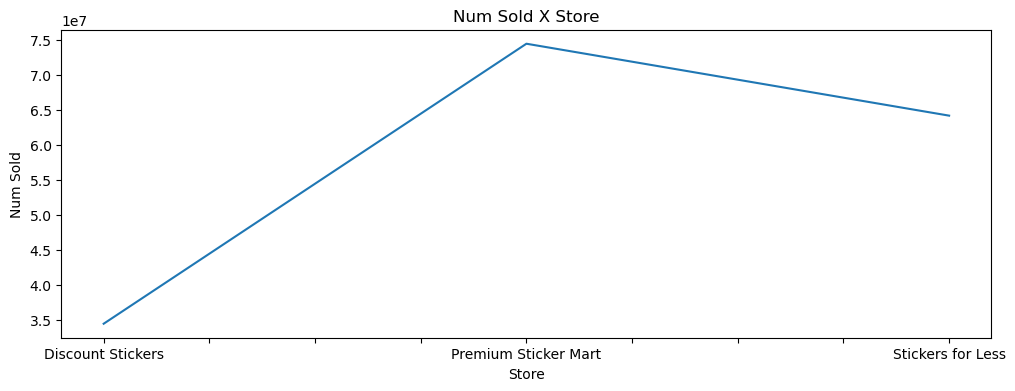

In [53]:
# best seller store
train_df.groupby("store")["num_sold"].sum().plot(figsize=(12, 4))

plt.title("Num Sold X Store")
plt.xlabel("Store")
plt.ylabel("Num Sold")
plt.show()

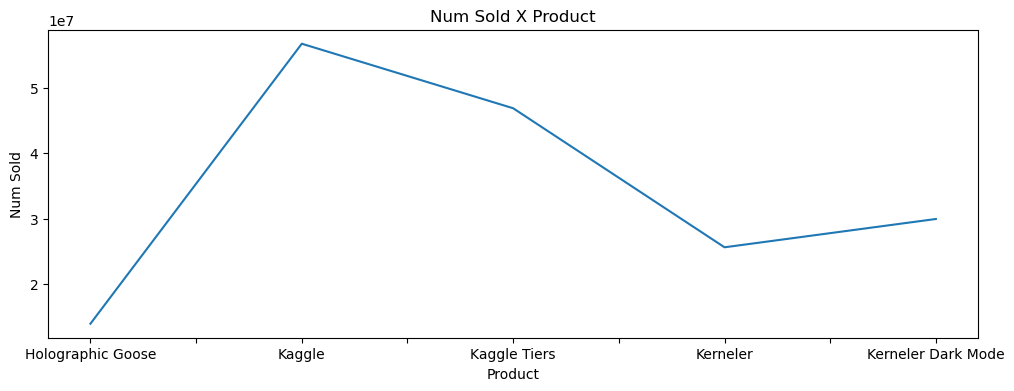

In [54]:
# best seller product
train_df.groupby("product")["num_sold"].sum().plot(figsize=(12, 4))

plt.title("Num Sold X Product")
plt.xlabel("Product")
plt.ylabel("Num Sold")
plt.show()

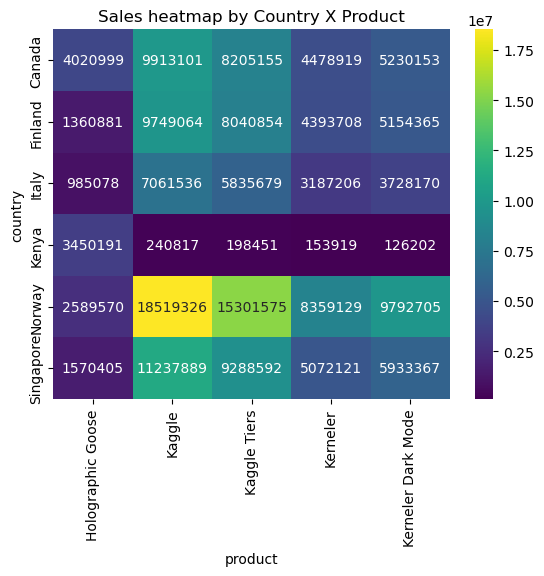

In [55]:
# check for the most sale location
heatmap_data = train_df.pivot_table(values="num_sold", index="country", columns="product", aggfunc="sum")

sns.heatmap(data=heatmap_data, cmap="viridis", annot=True, fmt=".0f")
plt.title("Sales heatmap by Country X Product")
plt.show()

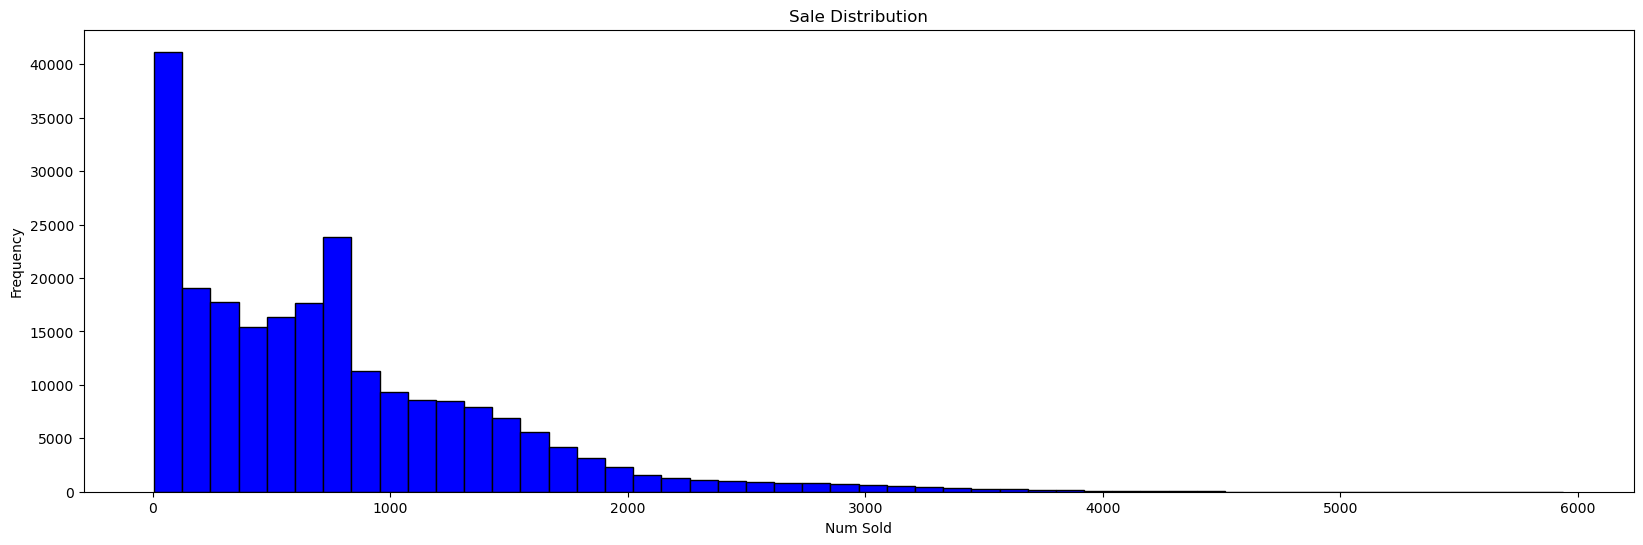

In [56]:
# Sale Distribution
plt.figure(figsize=(20, 6))
plt.hist(train_df["num_sold"], bins=50, color="blue", edgecolor="black")
plt.title("Sale Distribution")
plt.xlabel("Num Sold")
plt.ylabel("Frequency")
plt.show()

# Data feature engineering

In [57]:
# adding interaction features
def interaction_features(X):
    X["country_store"] = X["country"] + "_" + X["store"]
    X["country_product"] = X["country"] + "_" + X["product"]
    X["store_product"] = X["store"] + "_" + X["product"]
    X["store_country"] = X["store"] + "_" +  X["country"]
    X["country_store_product"] = X["country"] + "_" + X["store"] + "_" + X["product"]
    return X

# convert timestamp data into numerical data
def calculate_week_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(np.ceil(adjusted_dom / 7.0))

def date_encoder(X):
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["weekOfMonth"] = X["date"].apply(calculate_week_month)
    X["dayOfWeek"] = X["date"].dt.dayofweek
    X["dayOfWeekSin"] = np.sin(2 * np.pi * X["dayOfWeek"] / 7)
    X["dayOfWeekCos"] = np.cos(2 * np.pi * X["dayOfWeek"] / 7)
    X = X.drop(columns=["date"])
    return X

# convert categorical data into numerical data
label = LabelEncoder()
def categorical_encoder(X):
    columns = ["country", "store", "product", "country_store", "country_product", "store_product", "store_country", "country_store_product"]
    for col in columns:
        X[col] = label.fit_transform(X[col])
    return X

# removing unnecessary columns
train_df_encoded = train_df.drop(columns=["id", "num_sold"])
test_df_encoded = test_df.drop(columns=["id"])

# apply all the data feature engineering
train_df_encoded = interaction_features(train_df_encoded)
train_df_encoded = date_encoder(train_df_encoded)
train_df_encoded = categorical_encoder(train_df_encoded)

test_df_encoded = interaction_features(test_df_encoded)
test_df_encoded = date_encoder(test_df_encoded)
test_df_encoded = categorical_encoder(test_df_encoded)

train_df_encoded["num_sold"] = train_df["num_sold"]
train_df_encoded

,country,store,product,country_store,country_product,store_product,store_country,country_store_product,year,month,weekOfMonth,dayOfWeek,dayOfWeekSin,dayOfWeekCos,num_sold
0,0,0,0,0,0,0,0,0,2010,1,1,4,-0.433884,-0.900969,752.527382
1,0,0,1,0,1,1,0,1,2010,1,1,4,-0.433884,-0.900969,973.000000
2,0,0,2,0,2,2,0,2,2010,1,1,4,-0.433884,-0.900969,906.000000
3,0,0,3,0,3,3,0,3,2010,1,1,4,-0.433884,-0.900969,423.000000
4,0,0,4,0,4,4,0,4,2010,1,1,4,-0.433884,-0.900969,491.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,5,1,0,16,25,5,11,80,2016,12,5,5,-0.974928,-0.222521,466.000000
230126,5,1,1,16,26,6,11,81,2016,12,5,5,-0.974928,-0.222521,2907.000000
230127,5,1,2,16,27,7,11,82,2016,12,5,5,-0.974928,-0.222521,2299.000000
230128,5,1,3,16,28,8,11,83,2016,12,5,5,-0.974928,-0.222521,1242.000000


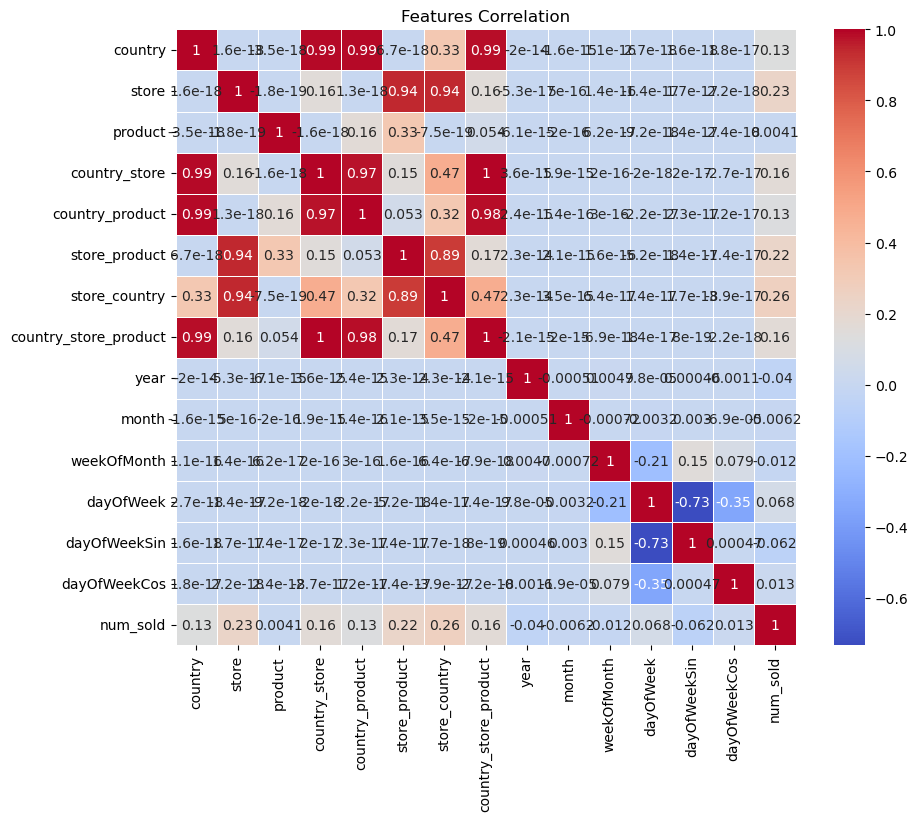

In [58]:
# check all features correlation after data converting
corr = train_df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, cmap="coolwarm", linewidths=0.5, annot=True)
plt.title("Features Correlation")
plt.show()

# Train model

In [59]:
# first we must to split data
X = train_df_encoded.drop(columns=["num_sold"])
y = np.log(train_df_encoded["num_sold"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

(184104, 14)

In [60]:
test_df_encoded.shape

(98550, 14)

In [61]:
def mape(ypred, y):
    return np.mean(np.abs((y - ypred)/ y)) * 100

In [62]:
# train and valuate various models
model1 = lgbm.LGBMRegressor()
model1.fit(X_train, y_train)

y_pred1 = model1.predict(X_val)
print(f"MODEL 1, mape loss 1 {mean_absolute_percentage_error(y_pred1, y_val)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 184104, number of used features: 14
[LightGBM] [Info] Start training from score 5.951563
MODEL 1, mape loss 1 0.018215286011190067


In [63]:
model2 = xgb.XGBRegressor()
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_val)
print(f"MODEL 2, mape loss 1 {mean_absolute_percentage_error(y_pred2, y_val)}")

MODEL 2, mape loss 1 0.016624033772557174


In [64]:
model3 = cb.CatBoostRegressor()
model3.fit(X_train, y_train)

y_pred3 = model3.predict(X_val)
print(f"MODEL 3, mape loss 1 {mean_absolute_percentage_error(y_pred3, y_val)}")

Learning rate set to 0.093338
0:	learn: 1.3932871	total: 4.76ms	remaining: 4.76s
1:	learn: 1.2819996	total: 8.81ms	remaining: 4.39s
2:	learn: 1.1836848	total: 12.8ms	remaining: 4.24s
3:	learn: 1.0947476	total: 16.3ms	remaining: 4.05s
4:	learn: 1.0158159	total: 19.8ms	remaining: 3.94s
5:	learn: 0.9450549	total: 23ms	remaining: 3.81s
6:	learn: 0.8817937	total: 27ms	remaining: 3.83s
7:	learn: 0.8251387	total: 30.3ms	remaining: 3.76s
8:	learn: 0.7729992	total: 33.5ms	remaining: 3.69s
9:	learn: 0.7290440	total: 36.8ms	remaining: 3.64s
10:	learn: 0.6898549	total: 40.4ms	remaining: 3.63s
11:	learn: 0.6554691	total: 43.9ms	remaining: 3.62s
12:	learn: 0.6228417	total: 47.7ms	remaining: 3.62s
13:	learn: 0.5926477	total: 51ms	remaining: 3.59s
14:	learn: 0.5671195	total: 54.1ms	remaining: 3.55s
15:	learn: 0.5450992	total: 57.7ms	remaining: 3.55s
16:	learn: 0.5267275	total: 61.3ms	remaining: 3.54s
17:	learn: 0.5092388	total: 64.4ms	remaining: 3.51s
18:	learn: 0.4952074	total: 68ms	remaining: 3.51s


In [72]:
prediction = np.sum(np.abs((y_val - y_pred1) / y_val) <= 0.05)
print(f"Final model, total {len(y_val)} and correct {prediction}")

Final model, total 46026 and correct 44037


In [69]:
# creating submission.csv and submit to kaggle
y_pred_kaggle = pd.DataFrame()
y_pred_kaggle["id"] = test_df["id"]
y_pred_kaggle["num_sold"] = model2.predict(test_df_encoded)

y_pred_kaggle.to_csv("submission.csv", index=False)
y_pred_kaggle

,id,num_sold
0,230130,6.694452
1,230131,6.637227
2,230132,6.566868
3,230133,5.885200
4,230134,6.114680
...,...,...
98545,328675,6.021190
98546,328676,7.762918
98547,328677,7.519995
98548,328678,6.881253
